# Sensitivity analysis

In [9]:
# System imports
import sys

# Data handling
import intake

# Custom functions from the authors' repo
sys.path.append("../src/general/")
sys.path.append("../src/pipelines/")
from make_scatter_data_plots_cloud import make_scatter_plots
from make_error_data_plots_cloud import make_error_plots

In [12]:
# Load the data
cat = intake.open_catalog(".././data/inputs_paper.yml")

mitgcm_filename = cat["MITGCM_model"]

#### Coefficient analysis (Figure 4)
Figure 4a shows coefficients averaged over all input locations for each variable type (i.e., for most variables, there are 27 inputs, corresponding to the 27 neighboring cells; we average over these to give a single value for each variable (temperature, salinity, etc.) and for each polynomial combination of variables). 

Figure 4b shows the coefficients related to polynomial interactions of temperature with temperature. These are the raw coefficients, without any averaging applied.

raw_coeffs.shape
(1, 26106)
raw_coeffs.shape
(1, 26106)


/Users/acoca/repos/contributing/notebooksnow/EDSbook-demo-myst-full/src/pipelines/coecien_analysis_cloud.py:156: RuntimeWarning: Mean of empty slice
  av_coeffs[i,j] = np.nanmean(coeffs[i_group_start:i_group_end, j_group_start:j_group_end])


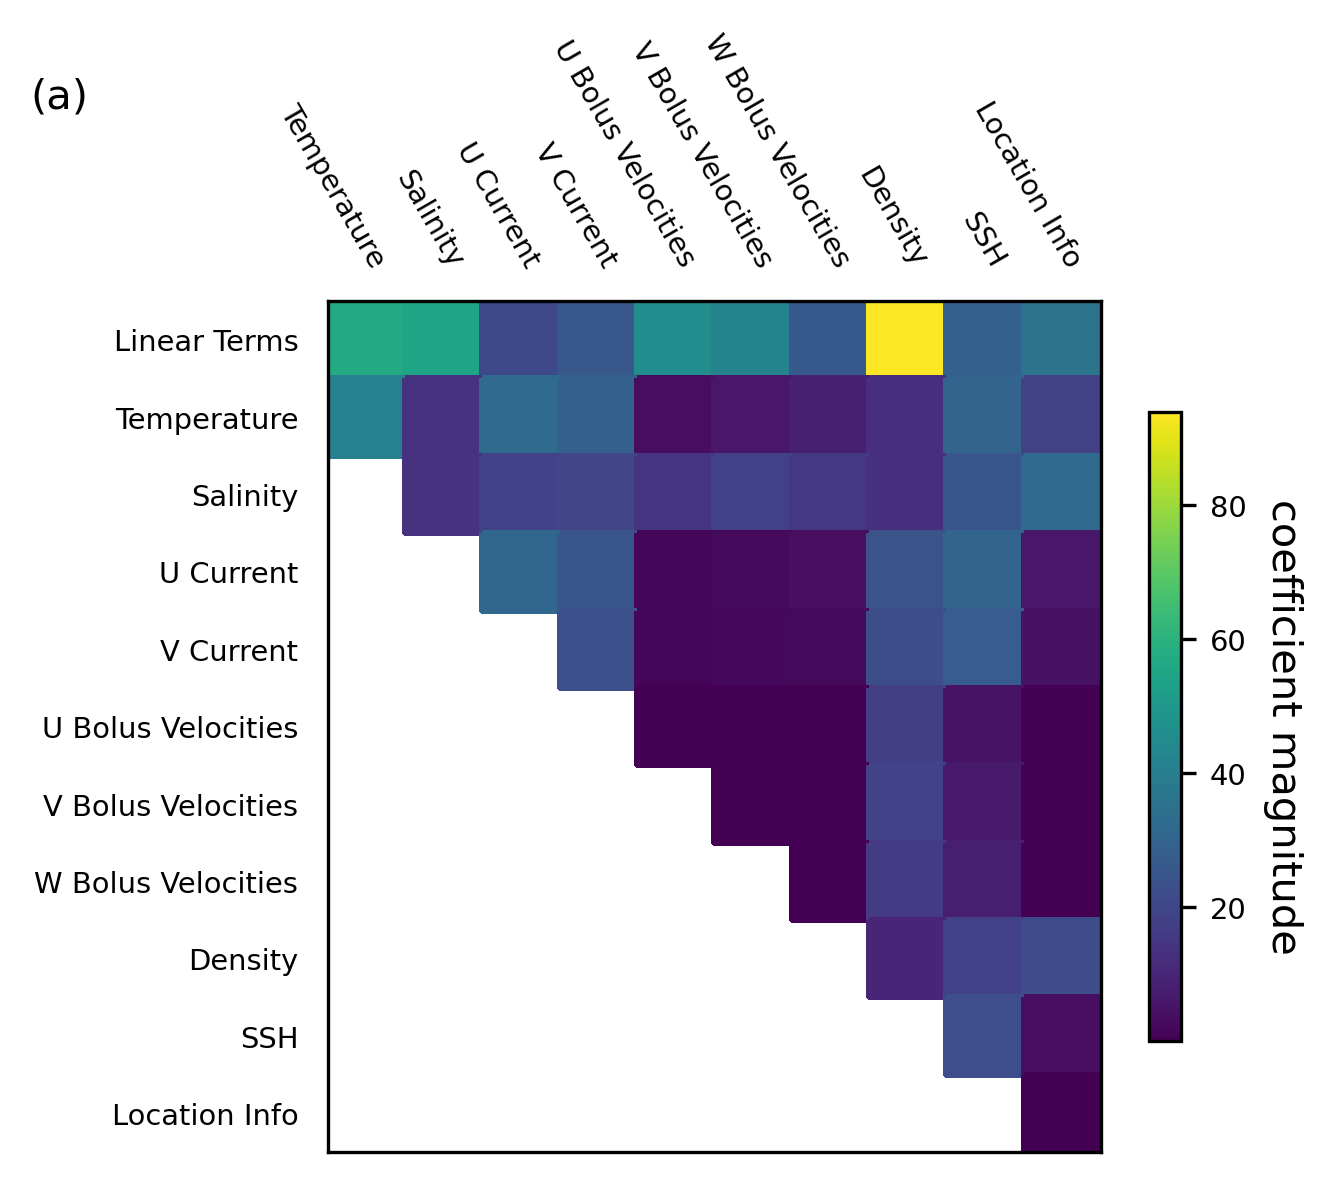

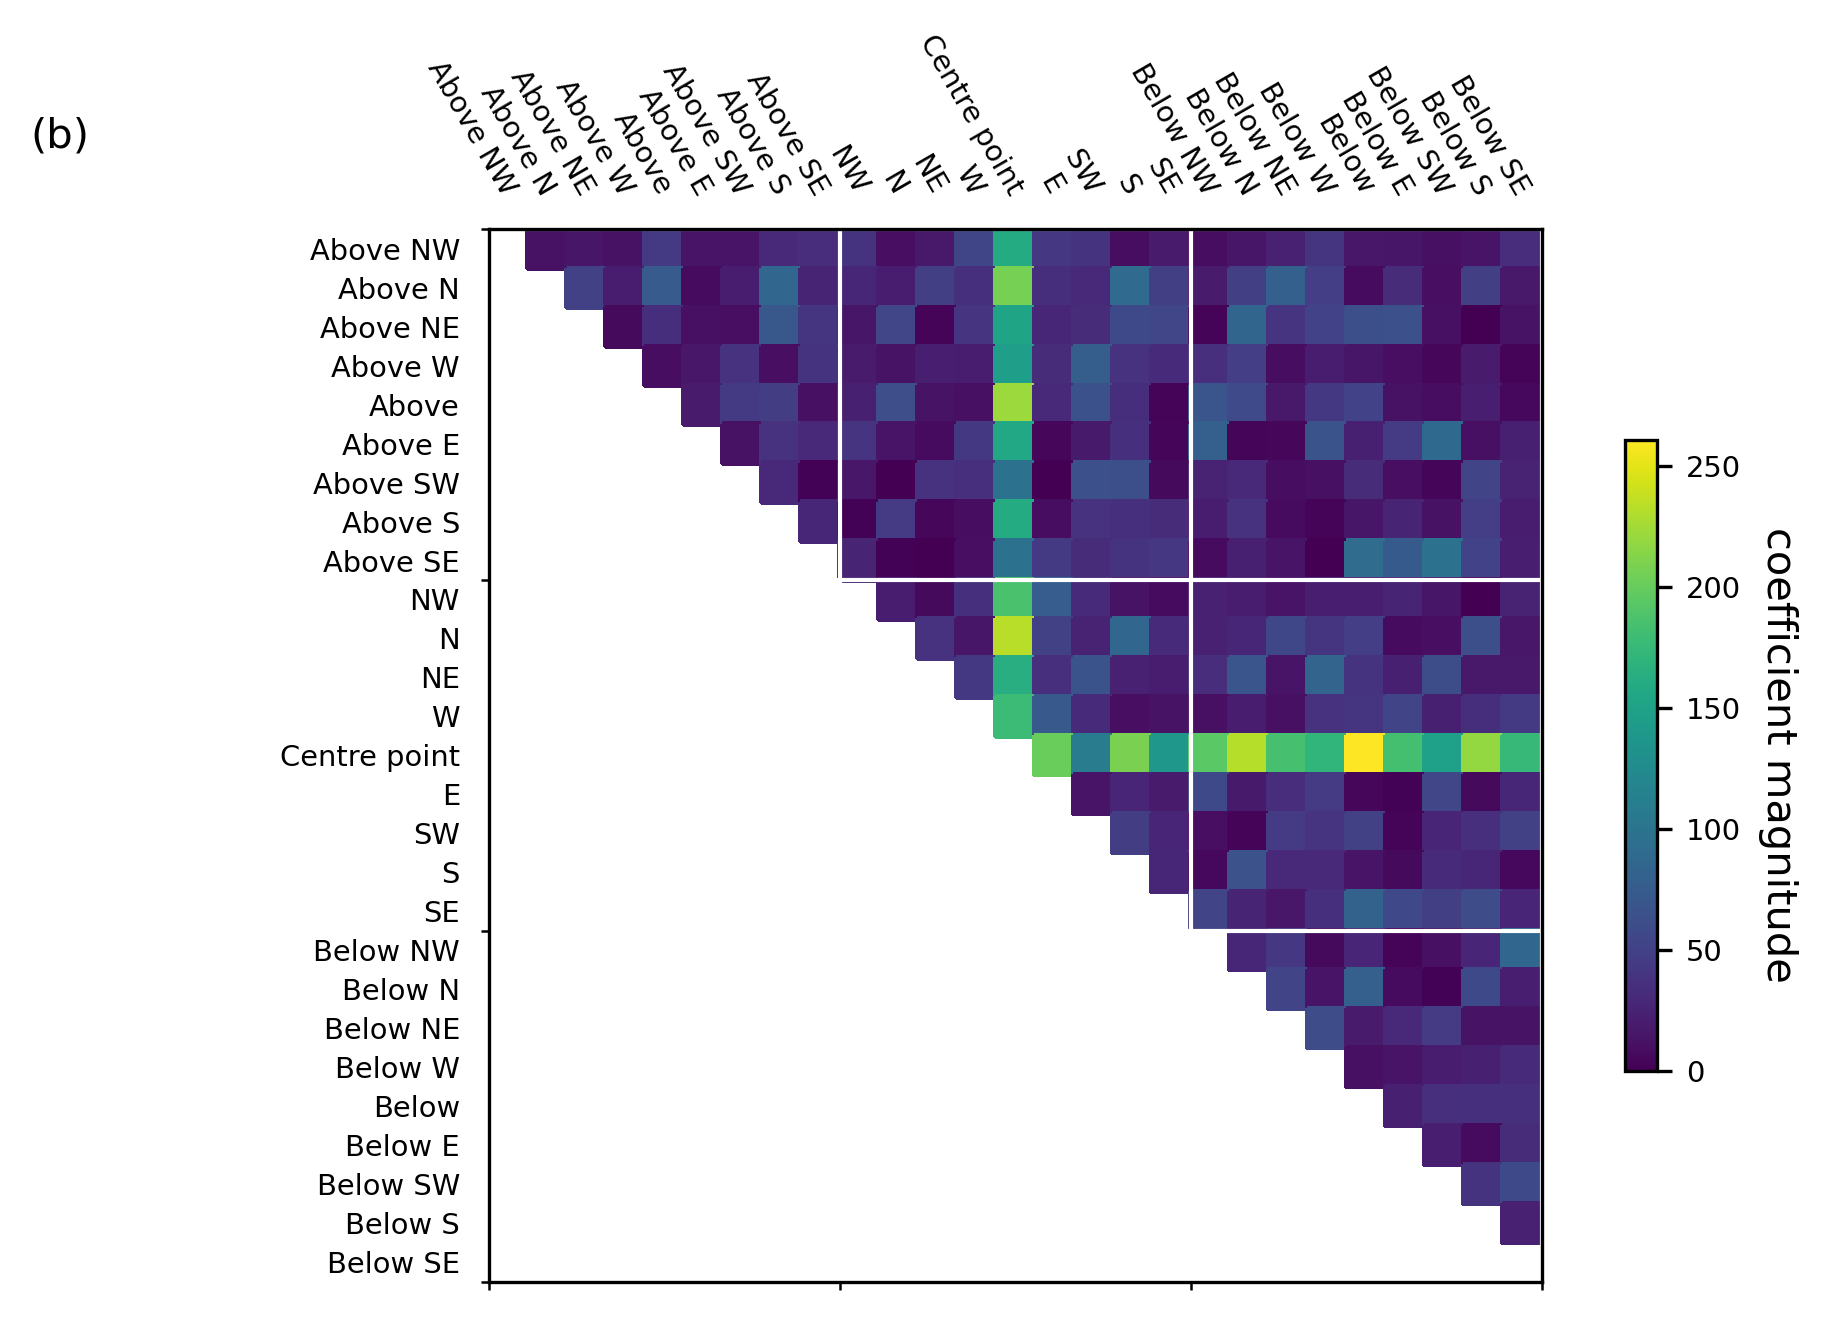

In [2]:
#| label: figure-4

%run ".././src/pipelines/coecien_analysis_cloud.py"

#### Witholding experiments
In this section, we run a series of withholding experiments. For each of the variables described with the exception of temperature, we train a new regressor leaving out that one variable group, for example, we train a new regressor with all the existing inputs except for salinity at all surrounding points and any multiplicative terms including salinity.

##### Withholding multiplicative terms: Figure 5; Importance of Non-Linearity
We update the dictionary `run_vars`, such that `poly_degree` is set to `1` -- This helps us in evaluating the performance of the purely linear model, that is, the model trained without any multiplicative terms.

In [3]:
# Setting up the parameters for the run - Setting Polynomial Degree=1
run_vars = {
    "dimension": 3,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 1,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name

In [4]:
# Path to the input arrays from an intake catalog
cat = intake.open_catalog(".././data/inputs_models.yml")

inputs_tr_filename = cat[model_name](partition="Tr")
inputs_val_filename = cat[model_name](partition="Val")

# Loading Input Arrays
norm_inputs_tr = inputs_tr_filename.to_dask()["norm_inputs_tr"]
norm_inputs_val = inputs_val_filename.to_dask()["norm_inputs_val"]

/Users/acoca/anaconda3/envs/team3_EDSbook/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/acoca/anaconda3/envs/team3_EDSbook/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


predict values

  Predictions against truth for Training datasets for the control regressor 




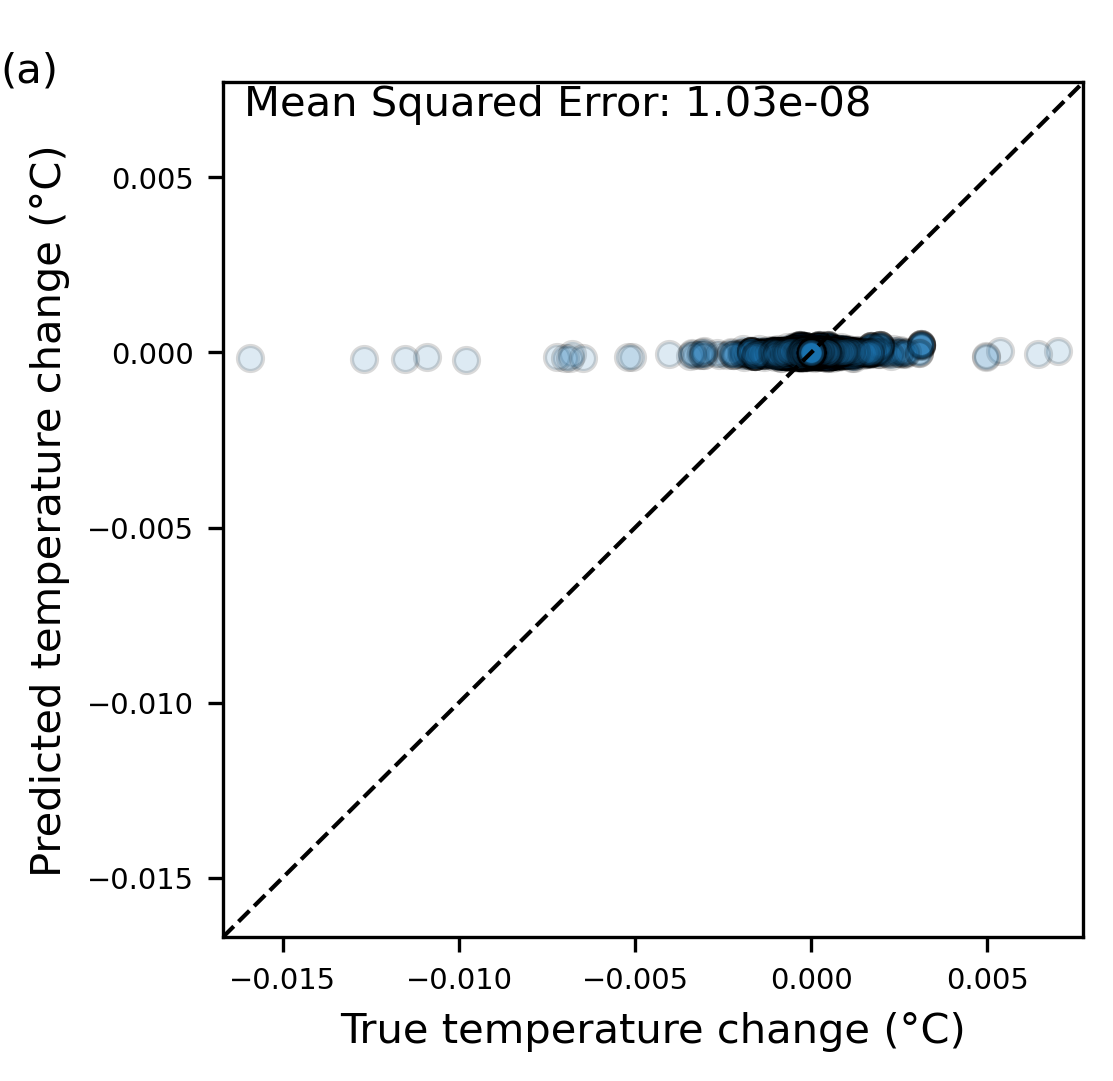

In [5]:
#| label: figure-5

make_scatter_plots(
    run_vars,
    data_name,
    model_name,
    norm_inputs_tr,
    norm_inputs_val,
    plot_val=False,
    fig_prefix="fig5",
)

##### Withholding 3D structure: Figure 6; Impact of vertical structure

To assess how information about the vertical structure of the ocean impacts predictions, we look at spatially averaged errors from the model trained with only a 2D neighborhood of inputs, along with the difference in error between this and the control regressor from previous Section.

We update the dictionary `run_vars`, such that `dimension` is set to `2`.

In [6]:
# Loading the 2D model
run_vars = {
    "dimension": 2,
    "lat": True,
    "lon": True,
    "dep": True,
    "current": True,
    "bolus_vel": True,
    "sal": True,
    "eta": True,
    "density": True,
    "poly_degree": 2,
    "StepSize": 1,
    "predict": "DelT",
}
data_name = data_prefix + cn.create_dataname(run_vars)
model_name = model_prefix + data_name
exp_name = exp_prefix + model_name
cntrl_name = (
    exp_prefix
    + model_prefix
    + data_prefix
    + "3dLatLonDepUVBolSalEtaDnsPolyDeg2_Step1_PredictDelT"
)



 Plotting the absolute error from predictions across the grid at 500 different times averaged to give a spatial pattern of errors. 




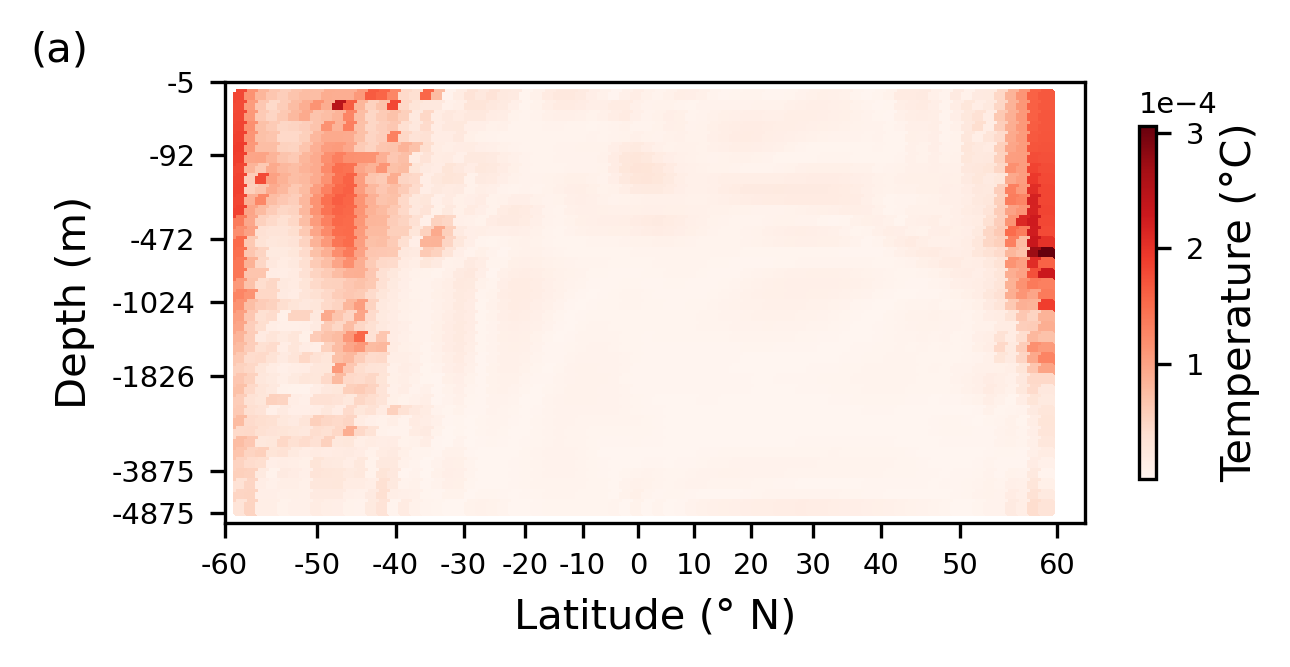



 Plotting the difference between this and the control run, with areas shaded in red indicating where the error has increased as a consequence of withholding information about the vertical structure, and blue indicating areas where the predictions are improved. 




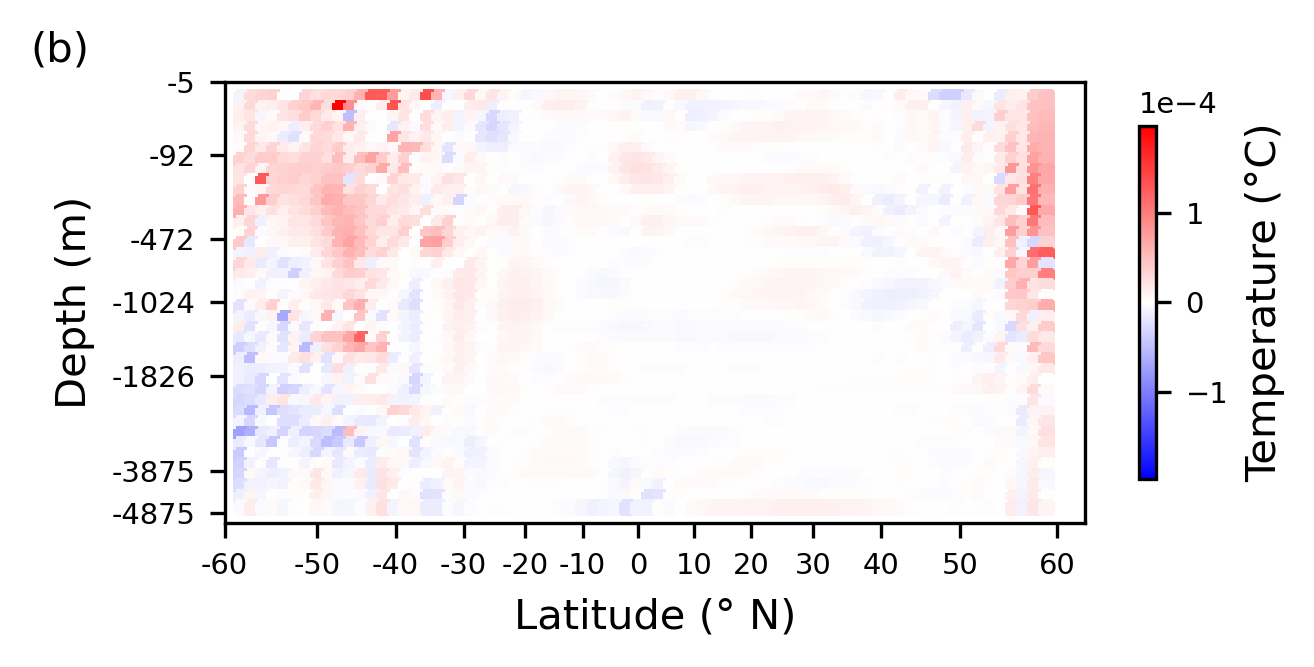

In [13]:
#| label: figure-6

make_error_plots(mitgcm_filename, exp_name, cntrl_name, fig_prefix="fig6")